#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

#### Reading data from text files

In [2]:
dia_all = pd.read_csv('task1_diabetes.txt')
train = pd.read_csv('task2_train.txt')
test = pd.read_csv('task2_test.txt')

# Splitting X independent and y dependent variables
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1:]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1:]

# Variable summary of full dataset
dia_all.describe().T

,count,mean,std,min,25%,50%,75%,max
preg,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
plas,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
pres,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skin,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insu,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
mass,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
pedi,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


## Task 1

#### 1.1) User defined Distance function

In [3]:
def distance_cw2(x,y):
    col = np.random.choice(len(x),3,replace=False)
    d=0
    for i in col:
        d += (x[i]-y[i])**2
    d=np.sqrt(d)
    return d

#### 1.2) Prepare Data

In [4]:
# Count zeros in multiple columns 
(dia_all == 0).astype(int).sum(axis=0)

preg     111
plas       5
pres      35
skin     227
insu     374
mass      11
pedi       0
age        0
class      0
dtype: int64

In [5]:
# We could see insu,skin and mass which usually can't be 0 so replace with median 
dia_all['mass'].replace(0,dia_all['mass'].median(), inplace = True)
dia_all['insu'].replace(0,dia_all['insu'].median(), inplace = True)
dia_all['skin'].replace(0,dia_all['skin'].median(), inplace = True)
dia_all['pres'].replace(0,dia_all['pres'].median(), inplace = True)

# Split dependent and independent variables
y = dia_all.iloc[:,-1:].to_numpy()
X = dia_all.iloc[:,:-1].to_numpy()

In [6]:
# Change dependent variable to binary using label encoding
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

#### 1.3) Function KNeighborsClassifier with multiple distance function and Neighbours experiment

In [7]:
def KNN_model(distance_metrics,neighbours,n_splits):

    k_fold_performance=[]

    for dist in (distance_metrics):

        for i in (neighbours):

            # Define KNN with multiple input parameters
            KNN = KNeighborsClassifier(n_neighbors=i,metric=dist) 

            # KFold definition with number of splits
            kf = KFold(n_splits=n_splits)
            j=0
            for train_index, test_index in kf.split(X):

                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Standardize the train data inorder for the KNN to find distance effectively 
                scaler = StandardScaler()
                scaled_X_train = scaler.fit_transform(X_train)
                
                # Fit transform the scaled data
                KNN = KNN.fit(scaled_X_train,y_train)
                
                # Standardize the test data
                scaled_X_test = scaler.transform(X_test)
                
                # Predicting the data from the model
                y_pred = KNN.predict(scaled_X_test)

                # Metrics creation
                accuracy=accuracy_score(y_test, y_pred)
                precision=precision_score(y_test, y_pred)
                recall=recall_score(y_test, y_pred)
                f1=f1_score(y_test, y_pred)
                k_fold_performance.append((dist,i,j,accuracy,precision,recall,f1))
                j=j+1

    cols=['Distance metric','n_neighbours','Split','Accuracy','Precision','Recall','F1_score']
    k_fold_performance = pd.DataFrame(k_fold_performance, columns=cols)
    k_fold_performance.iloc[int(len(k_fold_performance)*.75):,0] = 'distance_cw2'
    return k_fold_performance

In [8]:
%%time
# KNN_model(Type of distance metrics, K neighbours, n folds)
k_fold_performance = KNN_model(['euclidean','manhattan','chebyshev',distance_cw2],[1,3,5,7],10)
k_fold_performance

Wall time: 38.4 s


,Distance metric,n_neighbours,Split,Accuracy,Precision,Recall,F1_score
0,euclidean,1,0,0.623377,0.560000,0.437500,0.491228
1,euclidean,1,1,0.779221,0.608696,0.636364,0.622222
2,euclidean,1,2,0.649351,0.620690,0.529412,0.571429
3,euclidean,1,3,0.701299,0.612903,0.633333,0.622951
4,euclidean,1,4,0.701299,0.583333,0.518519,0.549020
...,...,...,...,...,...,...,...
155,distance_cw2,7,5,0.688312,0.687500,0.366667,0.478261
156,distance_cw2,7,6,0.779221,0.411765,0.500000,0.451613
157,distance_cw2,7,7,0.701299,0.583333,0.280000,0.378378
158,distance_cw2,7,8,0.671053,0.461538,0.250000,0.324324


#### 1.4) Aggregation and evaluation 

In [9]:
fold_avg = k_fold_performance.groupby(['Distance metric','n_neighbours'])[['Accuracy','Precision','Recall','F1_score']].mean().reset_index()
fold_std = k_fold_performance.groupby(['Distance metric','n_neighbours'])[['Accuracy','Precision','Recall','F1_score']].std().reset_index()

fold_avg['Accuracy SD']=fold_std['Accuracy']
fold_avg['Precision SD']=fold_std['Precision']
fold_avg['Recall SD']=fold_std['Recall']
fold_avg['F1_score SD']=fold_std['F1_score']
fold_avg.rename(columns={"Accuracy": "Avg_Accuracy", "Precision": "Avg_Precision","Recall":"Avg_Recall","F1_score":"Avg_F1_score"},inplace=True)
print('\tDistance and n_neighbours with various metrics')
fold_avg[['Distance metric','n_neighbours','Avg_Accuracy','Accuracy SD','Avg_Precision','Precision SD','Avg_Recall','Recall SD','Avg_F1_score','F1_score SD']]

	Distance and n_neighbours with various metrics


,Distance metric,n_neighbours,Avg_Accuracy,Accuracy SD,Avg_Precision,Precision SD,Avg_Recall,Recall SD,Avg_F1_score,F1_score SD
0,chebyshev,1,0.694036,0.056687,0.559071,0.074112,0.556199,0.078424,0.553216,0.061748
1,chebyshev,3,0.712201,0.056797,0.602214,0.085086,0.512870,0.077162,0.548906,0.063166
2,chebyshev,5,0.718694,0.054799,0.616979,0.104247,0.522678,0.082546,0.558304,0.069246
3,chebyshev,7,0.734279,0.058361,0.645917,0.131986,0.543537,0.075573,0.582923,0.084124
4,distance_cw2,1,0.619771,0.068506,0.464564,0.142022,0.425406,0.042128,0.437320,0.089030
5,distance_cw2,3,0.660048,0.050039,0.503874,0.134158,0.339968,0.100546,0.401993,0.112604
6,distance_cw2,5,0.669293,0.060825,0.545655,0.107185,0.353920,0.060850,0.422251,0.057719
7,distance_cw2,7,0.671839,0.062574,0.556063,0.112229,0.309734,0.093987,0.388699,0.079221
8,euclidean,1,0.691422,0.042329,0.558117,0.105463,0.560156,0.060781,0.552594,0.073707
9,euclidean,3,0.729152,0.053510,0.623217,0.151162,0.529626,0.096460,0.569877,0.119829


In [10]:
overall_avg = k_fold_performance.groupby(['Distance metric'])[['Accuracy']].mean().reset_index()
overall_std = k_fold_performance.groupby(['Distance metric'])[['Accuracy']].std().reset_index()
overall_avg['Average SD']=overall_std['Accuracy']
overall_avg.rename(columns={"Accuracy": "Avg_Accuracy"})
print('\tDistance with its overall accuracy and Standard deviation \n\t We see overall Euclidean performs the best ')
overall_avg

	Distance with its overall accuracy and Standard deviation 
	 We see overall Euclidean performs the best 


,Distance metric,Accuracy,Average SD
0,chebyshev,0.714803,0.056378
1,distance_cw2,0.655238,0.062193
2,euclidean,0.724919,0.052690
3,manhattan,0.712252,0.062753


#### 1.5) Visualize the results

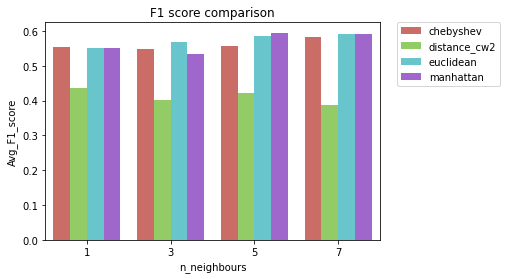

In [11]:
palette = sns.color_palette("hls",4)
# ch1 = sns.lineplot(data=k_fold_performance,y='F1_score',x='Split',hue='n_neighbours',palette=palette)
ch1 = sns.barplot(data=fold_avg,y='Avg_F1_score',x='n_neighbours',hue='Distance metric',palette=palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ch1.set(ylim=(0, 1))
plt.title('F1 score comparison')
plt.show()

#### Overall for 7 neighbours euclidean performs best in terms of Accuracy and F1 Score. Hence we can finalize the the same model. 

   ## Taks 2 Impact of Noise 

#### 2.1) Function for Multimodel (KNN, DT, MLP) evaluation

In [12]:
%%time

def noise_models(no_of_random_state,noise):
    
    dt=[]
    for rand in range(0,no_of_random_state):

        for i in range(noise[0],noise[1]+1,noise[2]):
            
            noise_per = int(i*len(train)/100) # Generate noise percent based on parameters

            train_X = train.iloc[:,:-1]
            train_y = train.iloc[:,-1:]
            
            if i>0: # Creating error wrt noise percent 
                x_train, x_test, y_train, y_noise = train_test_split(train_X, train_y, test_size=noise_per ,random_state=rand)
                y_noise = y_noise['class'].apply(lambda x: 0 if x>0 else 1).to_frame()
                train_X = pd.concat([x_train,x_test])
                train_y = pd.concat([y_train,y_noise])

            scaler = StandardScaler()
            scaled_train_X = scaler.fit_transform(train_X) # Scale train set for training 
            scaled_test_X = scaler.transform(test_X) # Scale test set before prediction

            # K Nearest Neighbors model 
            KNN = KNeighborsClassifier(n_neighbors=5,weights='distance')
            KNN = KNN.fit(scaled_train_X,train_y)
            pred_y = KNN.predict(scaled_test_X)

            dt.append(('KNN',i,noise_per,rand,accuracy_score(test_y, pred_y),precision_score(test_y, pred_y),recall_score(test_y, pred_y),f1_score(test_y, pred_y)))
            
            # Decision Tree model 
            DT = DecisionTreeClassifier()
            DT = DT.fit(scaled_train_X,train_y)
            pred_y = DT.predict(scaled_test_X)

            dt.append(('DT',i,noise_per,rand,accuracy_score(test_y, pred_y),precision_score(test_y, pred_y),recall_score(test_y, pred_y),f1_score(test_y, pred_y)))
            
            # Deep Neural Network
            clf = MLPClassifier(hidden_layer_sizes=(8,3)).fit(scaled_train_X, train_y)
            pred_y = clf.predict(scaled_test_X)

            dt.append(('MLP',i,noise_per,rand,accuracy_score(test_y, pred_y),precision_score(test_y, pred_y),recall_score(test_y, pred_y),f1_score(test_y, pred_y)))

    cols=['Model','Noise_per','Random_state','Records_modified','Accuracy','Precision','Recall','F1_score']
    dt = pd.DataFrame(dt, columns=cols)
    return dt

Wall time: 0 ns


#### 2.2) Call the function to generate results

In [13]:
# noise_model(no_of_random_state,[start_per,stop_per,increment])
dt = noise_models(50,[0,30,2])

#### 2.3)Visualise the data

In [14]:
# Aggregating results 
results = dt.groupby(['Model','Noise_per'])[['Accuracy','Precision','Recall','F1_score']].mean().reset_index()
tp = dt.groupby(['Model'])[['Accuracy','F1_score']].mean().reset_index()

In [15]:
# Chart data preparation 
s = []
for i in range(0,len(tp)):
    for p in range(0,31):
        s.append((p,tp['Model'][i],tp['Accuracy'][i],tp['F1_score'][i]))

col = ['idx','Model', 'Accuracy','F1_score'] 
s = pd.DataFrame(s,columns=col)
s['Model'].replace(s['Model'].values,s['Model']+' overall avg F1 score', inplace = True)
results['Model'].replace(results['Model'].values,results['Model']+' accuracy line', inplace = True)

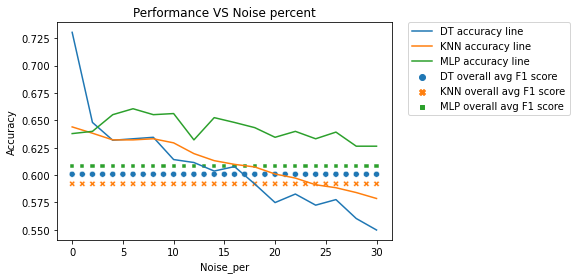

In [16]:
# Seaborn chart comparing how percent of errors affecting the accuracy and F1 score
palette = sns.color_palette("hls",4)
ch1 = sns.lineplot(data=results,y='Accuracy',x='Noise_per',hue='Model')
# ch1.set(ylim=(0.3, 0.8))
ch2 = sns.scatterplot(s['idx'],s['F1_score'],hue=s['Model'], style=s['Model'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Performance VS Noise percent')

plt.show()

   ## Taks 3 [Justification]

### Reflection on results

#### Task 1

Various Distance metrics is compared with different neighbours and 10 folds in task 1. Data is processed by label encoding of the dependent variable, replace medium value for columns where 0 not possible for example mass, skin and standardize the data using standard scaler explicitly for KNN. From 1.4 table(Accuracy and SD) we can infer that Euclidian distance performs better than other combinations in terms of accuracy and F1 score in multiple folds. This is also evident in the chart in 1.5 which compares F1 score of all four distance functions across n neighbours. For some combinations it be seen that accuracy crosses 80% yet those models can be overfitting on the train data. Manhattan is the second best but user defined distance function is performing bad since it is considering only 3 random independent variable each time distance is calculated. Advantage is that it simple to create model but the learning can be better when other algorithms like neural network, bagging and boosting methods with the expense of data. Importantly the data is very minimal when it is increased better accuracy can be obtained.

#### Task 2

Noise being created for task2_train set with 2% increment up to 30%. It is inferred from the graph 2.3 that more the noise the test accuracy tends to go down for almost all three models. It is because the model is learning with wrong data labels and fails when predicting the test set. This makes removing of noise from the training set a crucial part. In addition, it is advisable to standardize the data in case of KNN as we apply distance function because higher magnitude variable can nullify the  smaller ones(age and salary). Also in Neural Network unscaled data can result in slow convergence and unstable learning. 


When we compare the model performance deep neural network(DNN) found be having accuracy in most noise percent. The performance increased considerably after standardization. Furthermore hyperparameter tuning such as increasing layers, dropouts, batch size, validation set can improve the model efficiency in DNN. In Decision tree (DT) changing depth, criterion, sample split   and in KNN changing neighbours can improve results. Scarcity of data is the major problem in lower scores. Taking in more refined data by volume can enable algorithms to learn better and in turn improve accuracy. Model optimization technique such as Bayesian optimization can also improve model performance. 
